In [136]:
%matplotlib inline

In [137]:
import sys
sys.path.append('../src/')

import glob
import warnings

import numpy as np
import pandas as pd
import xarray as xr

from scipy.optimize import curve_fit, minimize

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray

from sklearn.linear_model import LinearRegression

from epsilon_tools import *
from tools import str2date, avg_funs

import warnings
warnings.simplefilter("ignore",category=FutureWarning)
warnings.simplefilter("ignore",category=RuntimeWarning)

# set up figure params
sns.set(style='ticks', context='poster', palette='colorblind')
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)


In [7]:
from xarrayutils.vertical_remapping import xr_remapping

In [1007]:
path = '../data/xarray/qc_7700b.nc'
data = xr.open_dataset(path)

z = data.z
rho = data.rho0- 1000

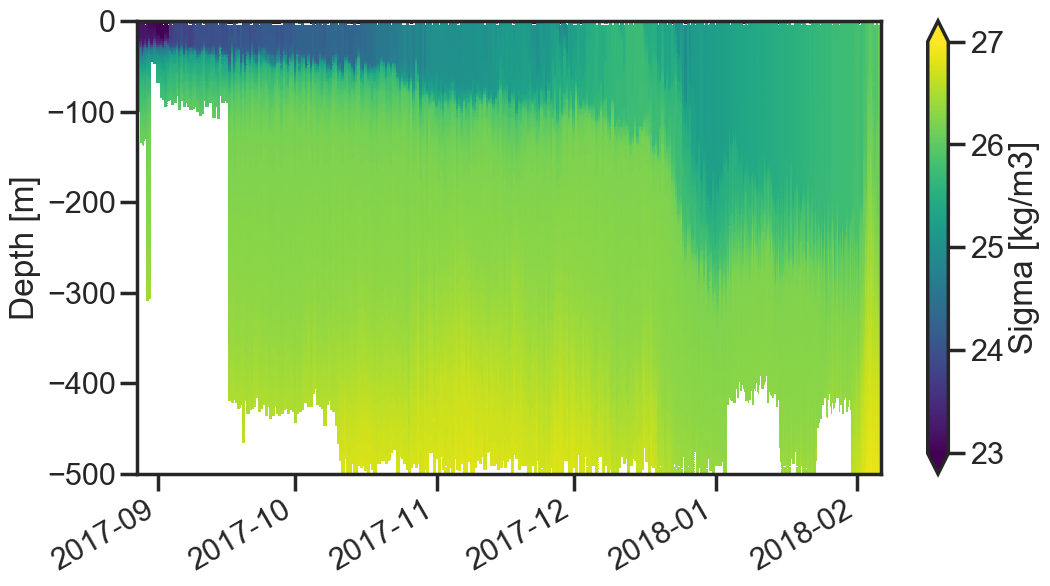

In [1008]:
rho.plot(vmin=23,vmax=27,
                 cbar_kwargs={'label':'Sigma [kg/m3]'})
plt.ylabel('Depth [m]');
plt.xlabel(None);
plt.ylim(-500,0);

In [980]:
mrho = rho.median('time')
zpicks = np.linspace(-500,-5,500)
rhobins = np.unique( mrho.interp(z=zpicks).values )

In [981]:
bins=np.linspace(20,30,200)
bins=np.sort( rhobins )

In [982]:
data['zmap'] = data.z
data['sigma'] = data.rho0-1000
data['sigma'],data['zmap'] = xr.broadcast(data.sigma,data.zmap)

In [983]:
remap = xr_remapping(data.zmap,data.sigma,bins, dim='z', distance_coord='z')

(25, 26.8)

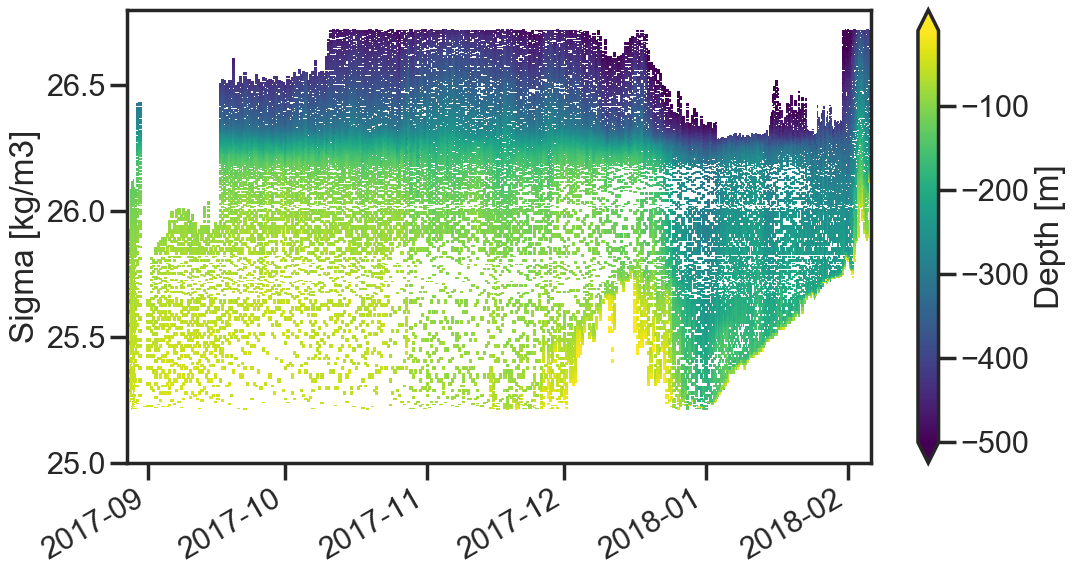

In [986]:
plt.figure(figsize=(12,6))
remap.plot(x='time', vmin=-500,vmax=-10,
                 cbar_kwargs={'label':'Depth [m]'})
plt.ylabel('Sigma [kg/m3]');
plt.xlabel(None);
plt.ylim(25,26.8)

In [1108]:
meansigma = data.rolling(time=20).reduce(np.nanmean)
meansigma['zmap'] = meansigma.z
meansigma['sigma'] = meansigma.rho0-1000
meansigma['sigma'],meansigma['zmap'] = xr.broadcast(meansigma.sigma,meansigma.zmap)

In [1109]:
remap_mean = xr_remapping(meansigma.zmap,meansigma.sigma,bins, dim='z', distance_coord='z')

In [1110]:
ds = xr.Dataset()
ds['displ'] = (remap-remap_mean)
ds['depth'] = remap

(25, 26.8)

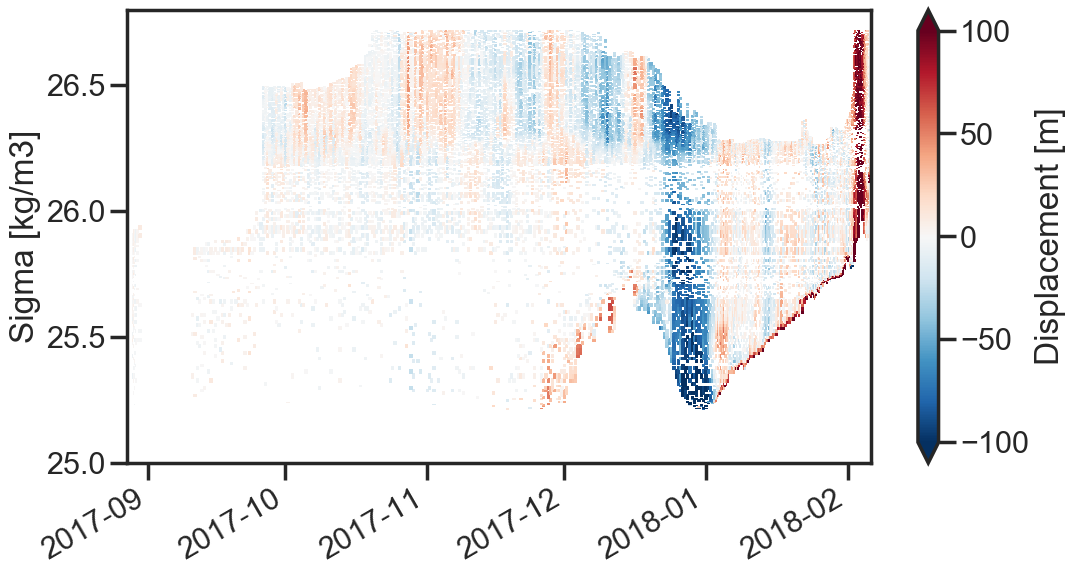

In [1111]:
ds.displ.plot(x='time',cmap='RdBu_r',
                 cbar_kwargs={'label':'Displacement [m]'}, vmin=-100,vmax=100)
plt.ylabel('Sigma [kg/m3]');
plt.xlabel(None);
plt.ylim(25,26.8)

In [1113]:
# remap = xr_remapping(data.zmap,data.sigma,bins, dim='z', distance_coord='z')
zbins=np.linspace(-500,-5,500)
ds['z'] = ds.depth
ds['sigma'],ds['z'] = xr.broadcast(ds.sigma_layer,ds.z)
remap_depth = xr_remapping(ds.sigma, ds.z, zbins, dim='sigma_layer', distance_coord='sigma_layer')

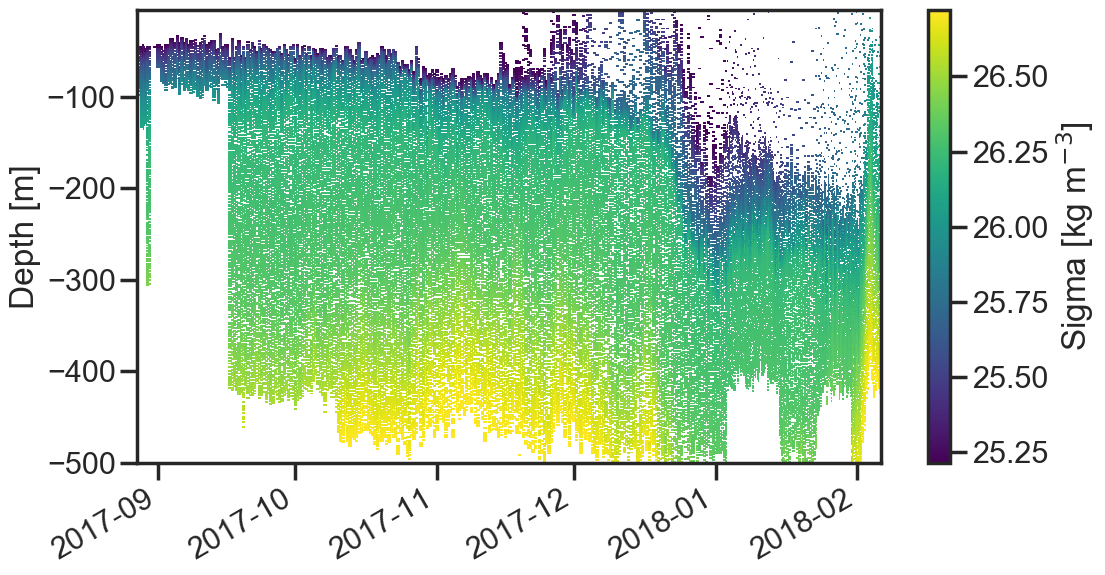

In [1114]:
remap_depth.plot(y='z_layer',
                 cbar_kwargs={'label':'Sigma [kg m$^{-3}$]'})
plt.ylabel('Depth [m]');
plt.xlabel(None);

In [1122]:
ds = ds.dropna('time',how='all',subset=['depth'])

In [1124]:
newz = np.linspace(-500,-5,500)
deck = []
for t,time in enumerate(ds.time):
    timeslice = ds.isel(time=t)
    timeslice = timeslice.assign_coords(depth=timeslice.depth).swap_dims({'sigma_layer':'depth'})
    timeslice = timeslice.groupby_bins('depth',newz).mean()
    deck.append(timeslice)

In [1125]:
zgrid = xr.concat(deck,'time')

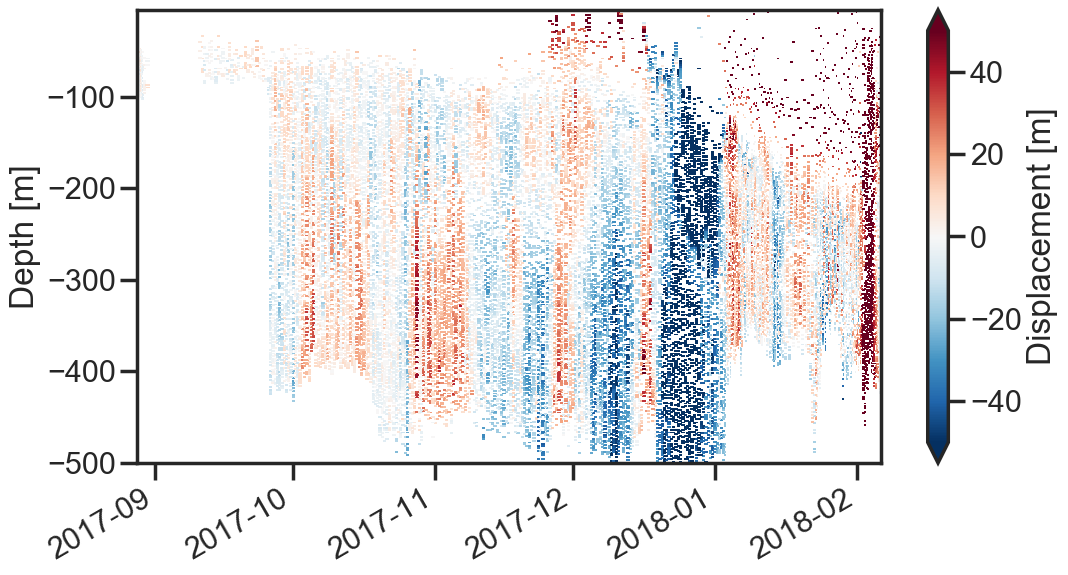

In [1126]:
zgrid.displ.plot(y='depth_bins',vmin=-50,vmax=50, cmap='RdBu_r',
                 cbar_kwargs={'label':'Displacement [m]'})
plt.ylabel('Depth [m]');
plt.xlabel(None);

In [1127]:
zgrid = zgrid.dropna('time', how='all',subset=['displ'])

In [1128]:
def m2km(x):
    return x/1000

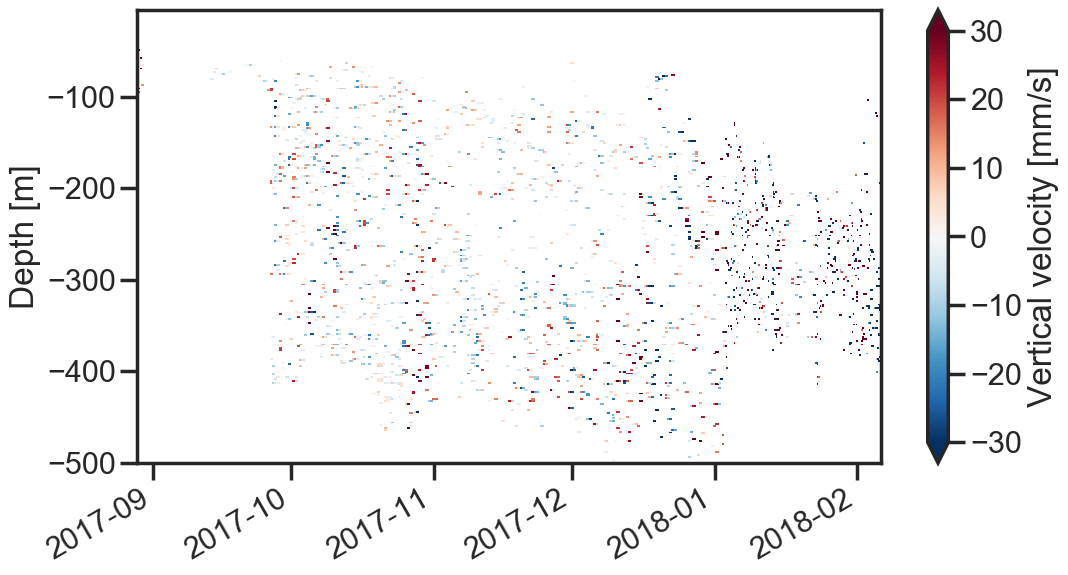

In [1129]:
zgrid.differentiate('time',datetime_unit='D').displ.plot(y='depth_bins',vmin=-30,vmax=30, cmap='RdBu_r',
                 cbar_kwargs={'label':'Vertical velocity [mm/s]'})
plt.ylabel('Depth [m]');
plt.xlabel(None);

In [1072]:
newz = np.linspace(-500,5,200)
deck = []
for t,time in enumerate(ds.time):
    timeslice = data.isel(time=t)
#     timeslice = timeslice.assign_coords(depth=timeslice.depth).swap_dims({'sigma_layer':'depth'})
    timeslice = timeslice.groupby_bins('z',newz).mean()
    deck.append(timeslice)

In [1073]:
data_zgrid = xr.concat(deck,'time')

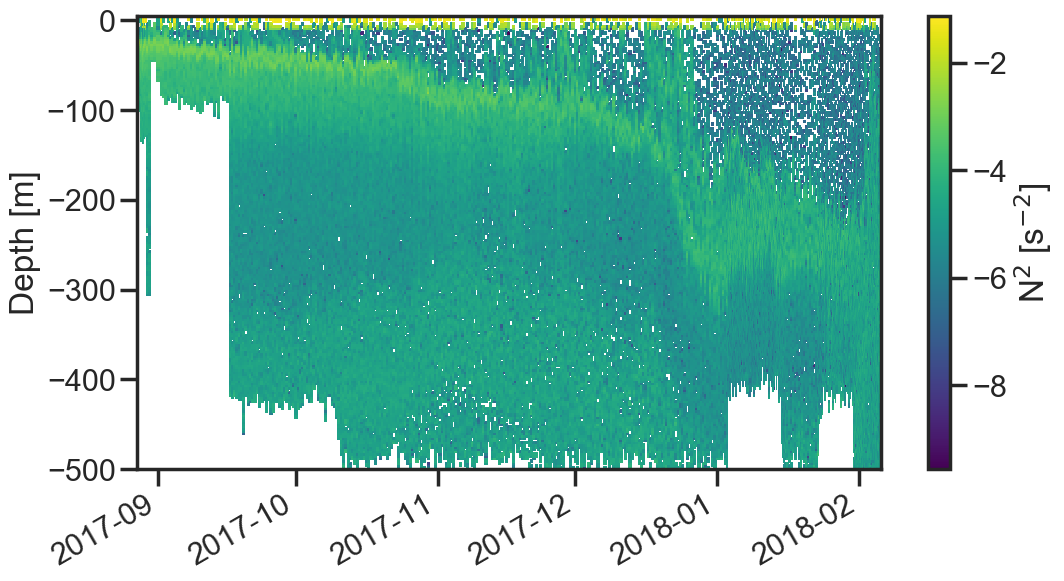

In [1074]:
data_zgrid.n2.pipe(np.log10).plot(y='z_bins',
                 cbar_kwargs={'label':r'N$^2$ [s$^{-2}$]'})
plt.ylabel('Depth [m]');
plt.xlabel(None);

In [1075]:
bin_labels = [v.mid for v in zgrid.depth_bins.values]
zgrid['zz'] = ('depth_bins',bin_labels)
zgrid = zgrid.assign_coords(zz=zgrid.zz).swap_dims({'depth_bins':'zz'})

In [1079]:
bin_labels = [v.mid for v in data_zgrid.z_bins.values]
data_zgrid['zz'] = ('z_bins',bin_labels)
data_zgrid = data_zgrid.assign_coords(zz=data_zgrid.zz).swap_dims({'z_bins':'zz'})

In [1096]:
PE = data_zgrid.n2*zgrid.displ**2/2
KE = (data_zgrid.u**2 + data_zgrid.v**2)/2

In [1102]:
data_zgrid.zz

<xarray.DataArray 'zz' (zz: 199)>
array([-498.731 , -496.1935, -493.656 , -491.118 , -488.5805, -486.043 ,
       -483.505 , -480.967 , -478.4295, -475.892 , -473.354 , -470.8165,
       -468.279 , -465.741 , -463.2035, -460.666 , -458.128 , -455.5905,
       -453.053 , -450.515 , -447.9775, -445.44  , -442.902 , -440.364 ,
       -437.8265, -435.289 , -432.751 , -430.2135, -427.676 , -425.138 ,
       -422.6005, -420.063 , -417.525 , -414.9875, -412.45  , -409.912 ,
       -407.3745, -404.837 , -402.299 , -399.761 , -397.2235, -394.686 ,
       -392.148 , -389.6105, -387.073 , -384.535 , -381.9975, -379.46  ,
       -376.922 , -374.3845, -371.847 , -369.309 , -366.7715, -364.234 ,
       -361.696 , -359.158 , -356.6205, -354.083 , -351.545 , -349.0075,
       -346.47  , -343.932 , -341.3945, -338.857 , -336.319 , -333.7815,
       -331.244 , -328.706 , -326.168 , -323.6305, -321.093 , -318.555 ,
       -316.0175, -313.48  , -310.942 , -308.4045, -305.867 , -303.329 ,
       -300.7915,

In [1103]:
zgrid.zz

<xarray.DataArray 'zz' (zz: 199)>
array([-498.7565, -496.269 , -493.7815, -491.294 , -488.8065, -486.319 ,
       -483.8315, -481.3445, -478.857 , -476.3695, -473.882 , -471.3945,
       -468.907 , -466.4195, -463.932 , -461.4445, -458.9575, -456.47  ,
       -453.9825, -451.495 , -449.0075, -446.52  , -444.0325, -441.5455,
       -439.058 , -436.5705, -434.083 , -431.5955, -429.108 , -426.6205,
       -424.133 , -421.6455, -419.1585, -416.671 , -414.1835, -411.696 ,
       -409.2085, -406.721 , -404.2335, -401.7465, -399.259 , -396.7715,
       -394.284 , -391.7965, -389.309 , -386.8215, -384.334 , -381.8465,
       -379.3595, -376.872 , -374.3845, -371.897 , -369.4095, -366.922 ,
       -364.4345, -361.9475, -359.46  , -356.9725, -354.485 , -351.9975,
       -349.51  , -347.0225, -344.535 , -342.0475, -339.5605, -337.073 ,
       -334.5855, -332.098 , -329.6105, -327.123 , -324.6355, -322.1485,
       -319.661 , -317.1735, -314.686 , -312.1985, -309.711 , -307.2235,
       -304.736 ,

ValueError: x and y must have same first dimension, but have shapes (439,) and (1,)

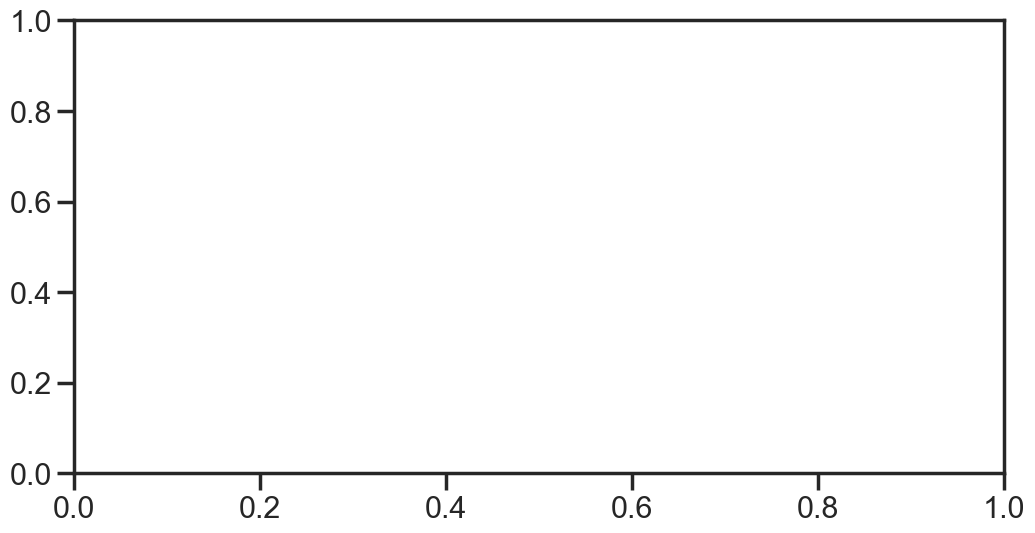

In [1099]:
PE.pipe(np.log10).plot(y='zz',cmap='viridis',vmin=-4,vmax=0,
                 cbar_kwargs={'label':r'PE [m$^{2}$ s$^{-2}$]'})
plt.ylabel('Depth [m]');
plt.xlabel(None);

In [ ]:
KE.pipe(np.log10).plot(y='depth_bins',cmap='viridis',vmin=-4,vmax=0,
                 cbar_kwargs={'label':r'KE [m$^{2}$ s$^{-2}$]'})
plt.ylabel('Depth [m]');
plt.xlabel(None);

In [ ]:
ratio = KE/PE

In [ ]:
ratio.pipe(np.log).plot(y='depth_bins',cmap='viridis',vmin=-10,vmax=10,
                 cbar_kwargs={'label':r'KE/PE'})
plt.ylabel('Depth [m]');
plt.xlabel(None);

In [ ]:
shear = (data_zgrid.dudz**2 + data_zgrid.dvdz**2)/2

In [ ]:
shear.pipe(np.log10).plot(y='depth_bins',cmap='viridis',vmin=-9,vmax=-3,
                 cbar_kwargs={'label':r'$(v_z)^2$'})
plt.ylabel('Depth [m]');
plt.xlabel(None);

In [ ]:
strain = zgrid.displ.differentiate('zz')

In [ ]:
strain.pipe(np.square).pipe(np.log10).plot(y='zz',cmap='viridis',vmin=-5,vmax=0,
                 cbar_kwargs={'label':r'$(\xi_z)^2$'})
plt.ylabel('Depth [m]');
plt.xlabel(None);

In [ ]:
bin_labels = [v.mid for v in shear.depth_bins.values]
shear['zz'] = ('depth_bins',bin_labels)
shear = shear.assign_coords(zz=shear.zz).swap_dims({'depth_bins':'zz'})

In [ ]:
st_ratio = shear.pipe(np.square)/strain.pipe(np.square)

In [ ]:
st_ratio.pipe(np.log10).plot(y='zz',cmap='viridis',vmin=-10,vmax=-5,
                 cbar_kwargs={'label':r'V$^2_z$/$\xi^2_z$'});
plt.xlabel(None)
plt.ylabel('Depth [m]')